In [2]:
#Import libraries and functions
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.integrate as spi
from diff_eqs import *

# How does seasonal temperature variation and timing of arbovirus co-circulation influence co-infection incidence?

### A short vignette implementing a deterministic, SEIR-SEI model for arbovirus co-infection under different temperature regimes.

First, we establish an environment with temperature mean and amplitude typical of a temperate region, similar to Beijing:

In [34]:
tempMean = 13.8
tempAmp = 14.7

We approximate within-year seasonal temperature variation using a sine curve, which then informs a range of temperature-sensitive mosquito life traits. We can visualize the temperature variation in a year like so:

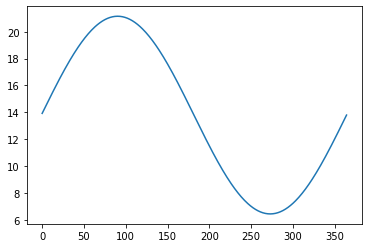

In [35]:
tvec = np.arange(1,366)
temp_t = temp_func(tempMean,tempAmp,tvec)
plt.plot(temp_t)

Next, we set values for temperature-independent parameters, including those governing cross protection, recovery time, duration of immunity, and more. Though we explored these extensively in a sensitivity analysis, right now we set them to their tuned, baseline values.

In [36]:
#Define global parameters

#parameters for cross protection, recovery, and timing
alpha = 0.0
alpha1H = alpha2H = alpha1M = alpha2M = alpha #cross protection
r = 5.0  #recovery rate
eiph = 7 #incubation period
ND = 1.0*365.25 #length of simulation
TS = 1.0 #timestep

#parameters for human-> mosquito cotransmission - 60%
p1M = p2M = 0.2
p12M = 1-p1M-p2M

#parameters for mosquito -> human cotransmission - 50% initially, varied later.
p1H = p2H = 0.25
p12H = 1-p1H-p2H

#To calculate gamma and restrict mosquito to human ratio
g = 1./(max(quadratic(25.1,9.16,37.73,-1.48e-01),0.01))
m = (100000+35000)/(26000+83000)  #from Massad modeling paper
gamma = m*g

Finally, we can set up and run the model. This function interfaces with underlying differential equations to simulate the introduction and spread of two arboviruses with identical, dengue-like transmission and recovery parameters.

In [37]:
def coinf_model(X, Y):
    virus2introduction = max(Y,X)   
    #one inital mosquito with virus X (if population a million)
    INPUT = np.zeros(27)
    INPUT[1] = 1e-5
    INPUT[11] = 5e-3
    INPUT[0] = 1-sum(INPUT[1:10])
    INPUT[10] = 1-sum(INPUT[11:14])
    
    #Times
    t_start = min(X,Y); t_end = ND+min(X,Y); t_inc = TS
    #this is the time that just virus X is circulating:
    t_range1 = np.arange(t_start, virus2introduction, t_inc) 
    
    #this is the time that both viruses are circulating:
    t_range2 = np.arange(virus2introduction, t_end+t_inc, t_inc)

    params = (tempMean,tempAmp,gamma,p1H,p2H,p12H,p1M,p2M,p12M,alpha1H,alpha2H,eiph,r)
    if Y != X:
    ##run the full model 
    #50% co-transmission

        RES1 = spi.odeint(diff_eqs,INPUT,t_range1,args=params)
        #Import a second infection
        INPUT2 = RES1[-1]
        INPUT2[2] = 1e-5 
        INPUT2[12] = 5e-3
        RES2 = spi.odeint(diff_eqs, INPUT2, t_range2, args = params)
        RES = np.concatenate((RES1, RES2))
        [SH, I1H, I2H, I12CH, I12SH, I1_2H, I2_1H, R1H, R2H, R12H,\
         SM, I1M, I2M, I12M, cumulative_I12CH, cumulative_I12SH, E1M, E2M,\
         E12M, E1H, E2H, E12CH, E12SH, E1_2H, E2_1H, I1E2M, I2E1M] = RES.T
    else:
        t_range = np.arange(t_start, t_end, t_inc)
        INPUT[2] = 1e-5
        INPUT[12] = 5e-3
        RES = spi.odeint(diff_eqs,INPUT,t_range, args=params)
        [SH, I1H, I2H, I12CH, I12SH, I1_2H, I2_1H, R1H, R2H, R12H,\
         SM, I1M, I2M, I12M, cumulative_I12CH, cumulative_I12SH, E1M, E2M,\
         E12M, E1H, E2H, E12CH, E12SH, E1_2H, E2_1H, I1E2M, I2E1M] = RES.T
    
    coinf_tot = (cumulative_I12SH[-1] + cumulative_I12CH[-1])
    return coinf_tot


Evaluating the below code will then allow us to consider the cumulative co-infection incidence over the course of a year-long simulation for each possible combination of virus arrival times, under the temperature regime we specified above.

Now we can visualize our results with a heatmap. Virus arrival times are on the axes, as are the associated temperature curves, and fill color indicates total annual co-infections observed. 

Text(0, 0.5, 'Day of arrival')

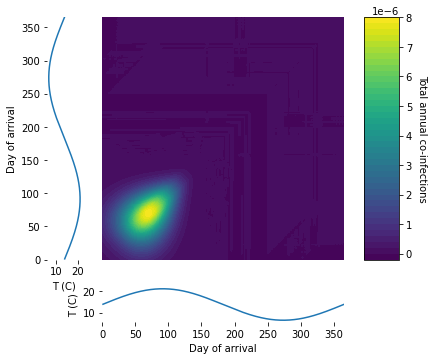

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         gridspec_kw={'height_ratios': [7,1], 
                                      'width_ratios': [1,7,1]},
                         figsize=(0.7*9,0.7*8))

contourplot = plt.contourf(virusAintro_grid,virusBintro_grid,coinfection_out,40,cmap = "viridis")
plt.gca().set_visible(False)
axes[0,1].contourf(virusAintro_grid,virusBintro_grid,coinfection_out,40,cmap = "viridis")
fig.colorbar(contourplot,cax=axes[0][2]).set_label('Total annual co-infections', rotation=270, labelpad = 15)
axes[1,0].axis('off')
axes[0,1].axis('off')
axes[1,2].axis('off')
tvec = np.arange(1,366)
axes[1,1].plot(tvec, temp_func(tempMean,tempAmp,tvec))
axes[1,1].set_xlim([0,365])
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['bottom'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].set_ylabel("T (C)")
axes[1,1].set_xlabel("Day of arrival")
axes[0,0].plot(temp_func(tempMean,tempAmp,tvec), tvec)
axes[0,0].set_ylim([0,365])
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['bottom'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].set_xlabel("T (C)")
axes[0,0].set_ylabel("Day of arrival")

Here, we can see that both simultaneous virus arrival and seasonal high temperatures are required to observe non-negligible co-infection; arrivals after the summer (around day 100) generate negligible co-infection incidence, as temperatures fall below those conducive to virus transmission.

### What if the temperature regime better resembles a tropical environment?

We can set our mean and amplitude to new values, these chosen to approximate Rio de Janeiro, and can plot the new sine curve as before, alongside the previous (in blue) as a point of reference.

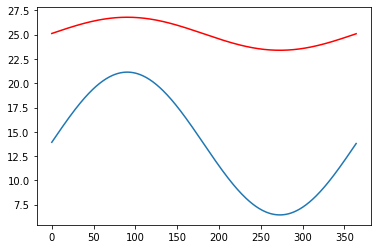

In [39]:
#Values for Rio de Janeiro
tempMean = 25.1
tempAmp = 3.4
plt.plot(temp_func(tempMean,tempAmp,tvec),color = "red")
plt.plot(temp_t)
plt.show()

We can then rerun the model with our new temperatures and plot it as before:

Text(0, 0.5, 'Day of arrival')

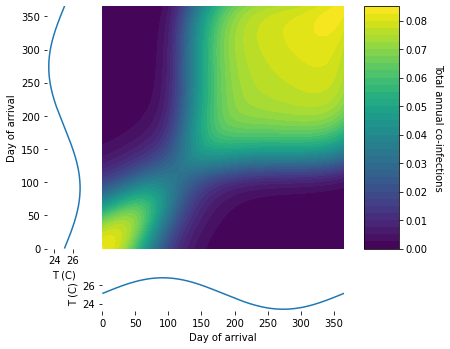

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3,
                         gridspec_kw={'height_ratios': [7,1], 
                                      'width_ratios': [1,7,1]},
                         figsize=(0.7*9,0.7*8))
contourplot = plt.contourf(virusAintro_grid,virusBintro_grid,coinfection_out_2,40,cmap = "viridis")
plt.gca().set_visible(False)
axes[0,1].contourf(virusAintro_grid,virusBintro_grid,coinfection_out_2,40,cmap = "viridis")
fig.colorbar(contourplot,cax=axes[0][2]).set_label('Total annual co-infections', rotation=270, labelpad = 15)
axes[1,0].axis('off')
axes[0,1].axis('off')
axes[1,2].axis('off')
tvec = np.arange(1,366)
axes[1,1].plot(tvec, temp_func(tempMean,tempAmp,tvec))
axes[1,1].set_xlim([0,365])
axes[1,1].spines['top'].set_visible(False)
axes[1,1].spines['right'].set_visible(False)
axes[1,1].spines['bottom'].set_visible(False)
axes[1,1].spines['left'].set_visible(False)
axes[1,1].set_ylabel("T (C)")
axes[1,1].set_xlabel("Day of arrival")
axes[0,0].plot(temp_func(tempMean,tempAmp,tvec), tvec)
axes[0,0].set_ylim([0,365])
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].spines['bottom'].set_visible(False)
axes[0,0].spines['left'].set_visible(False)
axes[0,0].set_xlabel("T (C)")
axes[0,0].set_ylabel("Day of arrival")

When seasonal patterns resemble those in a tropical region, same-day virus importation results in incidence of co-infection that is always non-negligible, although there are seasonal differences. For instance, periods of low incidence appear associated with periods of significant negative temperature change, particularly in late summer (days 100–150).

### We can conclude that, to observe substantial co-infection incidence in this model setting, we need both the consistently favorable temperatures typical of the tropics and temporal synchrony between the viruses.